In [69]:
from abc import ABC, abstractmethod
import numpy as np
from scipy.stats import multivariate_normal

class Model(ABC):
    @abstractmethod
    def train(self, train_inputs, train_labels):
        pass
    
    @abstractmethod
    def predict(self, test_inputs):
        pass

class Gaussian1d(Model):
    def train(self, train_inputs, train_labels):
        self.mean = np.mean(train_inputs, axis=0)
        self.variance = np.sum((train_inputs - self.mean) ** 2, axis=0) / train_inputs.shape[0]

        #  Test
        assert(np.abs(self.variance - np.var(train_inputs.T)) <= 0.00000000000001)

        self.first_half_pdf = 1 / np.sqrt(2 * np.pi * self.variance)
    
    def logpdf(self, x):
        diff = x - self.mean
        second_half_pdf = np.exp(-0.5 * diff ** 2 / self.variance)
        return np.log(self.first_half_pdf * second_half_pdf)
    
    def predict(self, test_inputs):
        predictions = np.zeros((test_inputs.shape[0]))
        for i, x in enumerate(test_inputs):
            predictions[i] = self.logpdf(x)
            
        return predictions
        
class DiagonalGaussian(Model):   
    def train(self, train_inputs, train_labels):
        # Check if we have more than one dimension
        if train_inputs.ndim > 1:
            self.mean = np.mean(train_inputs, axis=0)
            self.covariance = np.diag(np.sum((train_inputs - self.mean) ** 2, axis=0) / train_inputs.shape[0])
            #self.covariance = np.diag(np.diag(np.cov(train_inputs.T)))

            #  Test
            assert((np.abs(self.covariance - np.diag(np.diag(np.cov(train_inputs.T, bias=True)))) <= 0.00000000000001).all())

            self.inv_covariance = np.linalg.inv(self.covariance)
            self.first_half_pdf = 1 / np.sqrt((2 * np.pi) ** train_inputs.shape[1] * np.linalg.det(self.covariance))
            self.compute_log_pdf = self.__logpdf__
        else:
            # Numpy functions like inverse and cov require 2d matrix
            gaussian1d = Gaussian1d()
            gaussian1d.train(train_inputs, train_labels)
            self.compute_log_pdf = gaussian1d.logpdf
            self.mean = gaussian1d.mean
            self.covariance = gaussian1d.variance
    
    def __logpdf__(self, x):
        diff = x - self.mean
        second_half_pdf = np.exp(-0.5 * np.dot(np.dot(diff, self.inv_covariance), diff))
        return np.log(self.first_half_pdf * second_half_pdf)
    
    def logpdf(self, x):
        return self.compute_log_pdf(x)
    
    def predict(self, test_inputs):
        predictions = np.zeros((test_inputs.shape[0]))
        for i, x in enumerate(test_inputs):
            predictions[i] = self.logpdf(x)
            
        return predictions
    
    def test_predict(self, test_inputs):
        predictions = np.zeros((test_inputs.shape[0], 2))
        for i, x in enumerate(test_inputs):
            predictions[i, 0] = multivariate_normal.logpdf(x, mean=self.mean, cov=self.covariance)
            predictions[i, 1] = self.logpdf(x)
            
        assert((np.abs(predictions[:, 0] - predictions[:, 1]) <= 0.00000000000001).all())

class ParzenIsotropicGaussian(Model):
    def __init__(self, std = 1):
        self.std = std
        
    def train(self, train_inputs, train_labels):
        self.train_inputs = train_inputs
        self.train_labels = train_labels
        
        d = train_inputs.shape[1] if train_inputs.ndim > 1 else 1
        self.first_half_pdf = 1 / ((np.sqrt((2 * np.pi)) * self.std) ** d)
        #self.first_half_pdf = 1 / (np.sqrt((2 * np.pi) ** train_inputs.shape[1] * np.linalg.det(self.covariance)))
    
    def __logpdf__(self, x, mean):
        diff = x - mean
        second_half_pdf = np.exp(-0.5 * (np.linalg.norm(diff) / self.std) ** 2)
        #second_half_pdf = np.exp(-0.5 * np.dot(np.dot(diff, self.inv_covariance), diff))
        return np.log(self.first_half_pdf * second_half_pdf)

    def predict(self, test_inputs):
        predictions = np.zeros((test_inputs.shape[0]))
        for i, x in enumerate(test_inputs):
            for X in train_inputs:
                predictions[i] += self.__logpdf__(x, X)
                
        predictions /= train_inputs.shape[0]
        return predictions
    
    def test_predict(self, test_inputs):
        predictions = np.zeros((test_inputs.shape[0], 2))
        for i, x in enumerate(test_inputs):
            for X in train_inputs:
                predictions[i, 0] += multivariate_normal.logpdf(x, mean=X, cov=self.std ** 2)
                predictions[i, 1] += self.__logpdf__(x, X)
                
        predictions /= train_inputs.shape[0]
        assert((np.abs(predictions[:, 0] - predictions[:, 1]) <= 0.00000000000001).all())

In [70]:
# Test
data = np.loadtxt("./iris.txt")

# Multiple dimensions
train_inputs = data[:50, :4]
train_labels = data[:50, 4]

dg = DiagonalGaussian()
dg.train(train_inputs, train_labels)

parzen = ParzenIsotropicGaussian()
parzen.train(train_inputs, train_labels)

dg.test_predict(data[:50, :4])
parzen.test_predict(data[:50, :4])

# One dimension
train_inputs = data[:50, 0]
train_labels = data[:50, 4]

dg = DiagonalGaussian()
dg.train(train_inputs, train_labels)

parzen = ParzenIsotropicGaussian()
parzen.train(train_inputs, train_labels)

dg.test_predict(data[:50, 0])
parzen.test_predict(data[:50, 0])

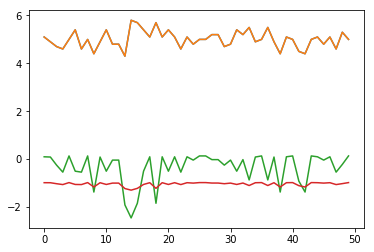

In [72]:
import matplotlib.pyplot as plt
train_inputs = data[:50, 0]
train_labels = data[:50, 4]

feature = data[:50, 0]

dg = DiagonalGaussian()
dg.train(train_inputs, train_labels)
dg_predictions = dg.predict(data[:50, 0])

parzen = ParzenIsotropicGaussian()
parzen.train(train_inputs, train_labels)
parzen_predictions = parzen.predict(data[:50, 0])

plt.plot(x)
plt.plot(dg_predictions)
plt.plot(parzen_predictions)
plt.show()